In [1]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import re
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


## Load data with drugcats added

In [2]:
adata = ep.io.read_csv("./adata_pneumonia_drugcats_added.csv", sep="\t")
adata


2023-08-17 16:00:31,375 - root INFO - Added all columns to `obs`.
2023-08-17 16:00:31,466 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `277` x `1291`.


AnnData object with n_obs × n_vars = 277 × 1291
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

In [3]:
adata.to_df().head()

,ehrapycat_received_rest_0.0,ehrapycat_received_rest_1.0,ehrapycat_sputum_positive_bacteria_0.0,ehrapycat_sputum_positive_bacteria_1.0,ehrapycat_sputum_positive_fungi_0.0,ehrapycat_sputum_positive_fungi_1.0,ehrapycat_ethnicity_Han_ethnic,ehrapycat_ethnicity_Miao_ethnic,ehrapycat_ethnicity_Others,ehrapycat_ethnicity_Tujia_ethnic,...,"drugcat_Fatty_Acids,_Unsaturated","drugcat_Fatty_Acids,_Monounsaturated",drugcat_Factor_VIII_Activator,drugcat_Explosive_Agents,drugcat_Expectorants,drugcat_Excitatory_Amino_Acid_Antagonists,drugcat_Excitatory_Amino_Acid_Agents,drugcat_Ethylene_Glycols,drugcat_Ethanolamines,drugcat_i.v._Solutions
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Input Phillips graph

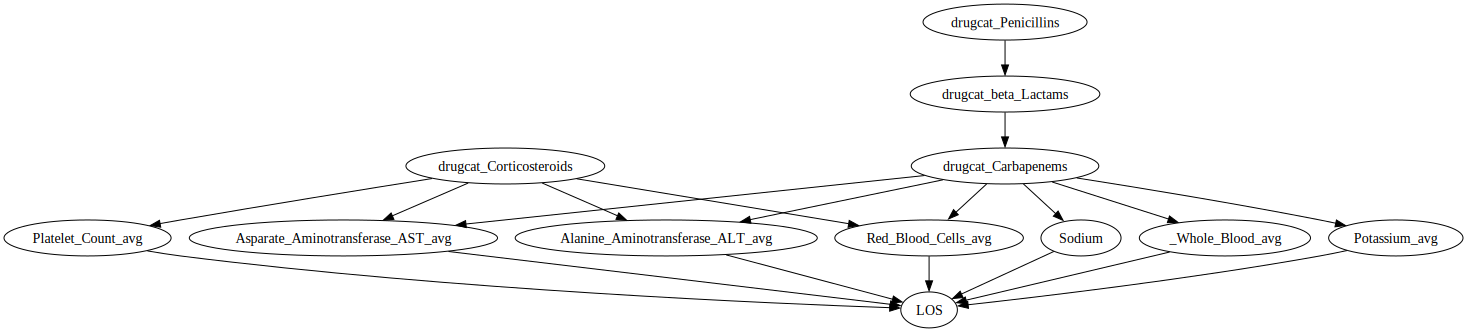

In [4]:
causal_graph = """digraph {
drugcat_Corticosteroids -> Asparate_Aminotransferase_AST_avg;
drugcat_Corticosteroids -> Alanine_Aminotransferase_ALT_avg;
drugcat_Corticosteroids -> Platelet_Count_avg;
drugcat_Corticosteroids -> Red_Blood_Cells_avg;
drugcat_Penicillins -> drugcat_beta_Lactams;
drugcat_beta_Lactams -> drugcat_Carbapenems;
drugcat_Carbapenems -> Asparate_Aminotransferase_AST_avg;
drugcat_Carbapenems -> Alanine_Aminotransferase_ALT_avg;
drugcat_Carbapenems -> Sodium,_Whole_Blood_avg;
drugcat_Carbapenems -> Potassium_avg;
drugcat_Carbapenems -> Red_Blood_Cells_avg;

Asparate_Aminotransferase_AST_avg -> LOS;
Alanine_Aminotransferase_ALT_avg -> LOS;
Platelet_Count_avg -> LOS;
Red_Blood_Cells_avg -> LOS;
Sodium,_Whole_Blood_avg -> LOS;
Potassium_avg -> LOS;
}"""

g = graphviz.Source(causal_graph)
display(g)

2023-08-17 16:00:52,927 - root WARNING - [dowhy] Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (1/5)
2023-08-17 16:00:53,531 - root WARNING - [dowhy] Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (2/5)
2023-08-17 16:00:54,230 - root WARNING - [dowhy] Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (3/5)
2023-08-17 16:00:54,860 - root WARNING - [dowhy] Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (4/5)
2023-08-17 16:00:55,540 - root WARNING - [dowhy] Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (5/5)
2023-08-17 16:00:57,653 - root WARNING - [dowhy] Refutation 'add_unobserved_common_cause' failed.
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                     
──────────────────────────(E[LOS])
d[drugcat_Corti

<Axes: title={'center': 'DoWhy estimate $\\rho$ (slope) = -7.066'}, xlabel='drugcat_Corticosteroids', ylabel='LOS'>

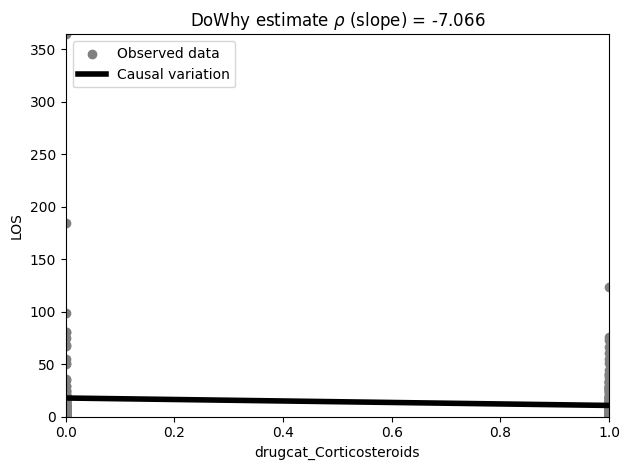

In [6]:
import anndata

e = ep.tl.causal_inference(
    adata=adata, 
    graph=causal_graph,
    treatment="drugcat_Corticosteroids", 
    outcome="LOS", 
    estimation_method="backdoor.linear_regression",
        refute_methods = [
        "placebo_treatment_refuter",
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause"
    ],
    print_causal_estimate=True,
    print_summary=True,
    show_graph=False,
    show_refute_plots="contour",
    return_as="estimate",
    identify_kwargs={"proceed_when_unidentifiable": True},
    attempts=5,
)
ep.pl.causal_effect(e)